# ETL: Preprocess all the font data and prepare a clean pickle that can be used for training
- Judiciously cut 3 images in 3 x 1 images 
- Transform text from Black on white to White on Black
- Normalize the image data to values from 0.0 to 1.0

---
Francois Robert

In [1]:
from platform import python_version

print(python_version())

3.8.3


In [2]:
import imageio
import numpy as np
import os
from pathlib import Path
from six.moves import cPickle as pickle
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## input and output files

In [3]:
# BASE_DIR is a directory created by GenerateFontImages MacOS app.
BASE_DIR = "/private/var/folders/dg/d26lcf2j32x077lbqlcjld5h0000gn/T/com.pixtolab.GenerateFontImages"
DIR_VERSION = "prep1"

PREP_DIR = os.path.join(BASE_DIR, DIR_VERSION)

INPUT_DIR  = os.path.join(PREP_DIR, "input")
OUTPUT_DIR = os.path.join(PREP_DIR, "output")

DATA_DIR   = os.path.join(INPUT_DIR, "font_data")

# Create output directory
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

OUT_DATAFILE = os.path.join(OUTPUT_DIR, DIR_VERSION + '.pickle')

In [4]:
# Functions for getting array of directory paths and array of file paths
def get_dir_paths(root):
    return [os.path.join(root, n) for n in sorted(os.listdir(root)) if os.path.isdir(os.path.join(root, n))]


def get_file_paths(root):
    return [os.path.join(root, n) for n in sorted(os.listdir(root)) if os.path.isfile(os.path.join(root, n))]

In [5]:
# Execution parameters are in a JSON configuration file
def load_params():
    fullfilename = os.path.join(PREP_DIR, "input", f"{DIR_VERSION}.param.json")
    with open(fullfilename) as json_file:
        data_dict = json.load(json_file)
        return data_dict

In [6]:
# Normalize image for all pixels. 0-255 -> 0.0-1.0
def normalize_image(image, pixel_depth):
    try:
        array = imageio.imread(image)
    except ValueError:
        raise

    return 1.0 - (array.astype(float)) / pixel_depth  # (1 - x) will make it white on black

In [7]:
# Find out where are the non white pixels in the image
def get_exact_image_size(image_data):
    mask = image_data != 0.0
    coords = np.argwhere(mask)
    # print("coords.min(axis=0) ", coords.min(axis=0))
    # print("coords.max(axis=0) ", coords.max(axis=0))

    x0, y0 = coords.min(axis=0)
    x1, y1 = coords.max(axis=0) + 1
    return x0, x1, y0, y1

In [8]:
# Function for loading data for a single font
# We will load:
# - 1x1 images containing 1 character
# - 3x1 images containing 3 characters
def load_one_font_data(dir, image_size, pixel_depth, verbose=True, min_nb_images=1, params=None):
    """Load data for a single font."""

    if verbose:
        print(dir)

    image_files = get_file_paths(dir)

    if params:
        nb1x1Images = params.get("nb_1_char", 0)
        nb1x3Images = params.get("nb_3_chars", 0)
    else:
        nb1x1Images = 86
        nb1x3Images = 250

    # Prepare a np array that will receive all the images
    dataset = np.ndarray(shape=(nb1x1Images + 3 * nb1x3Images, image_size, image_size), dtype=np.float32)

    image_index = 0
    for image in image_files:
        try:
            image_data_all_channels = normalize_image(image, pixel_depth)
            # print(image_data_all_channels.shape)
            image_data = image_data_all_channels[:, :, 0]
            # print(image_data.shape)

            # Images proportions can be 1x1 or 1x3
            if image_data.shape != (image_size, image_size):
                if image_data.shape != (image_size, 3 * image_size):
                    raise Exception('Unexpected image shape: %s' % str(image_data.shape))
                else:
                    # We consider 3 x 1 image as a kind of font "paste" in which will cut 3 images:
                    # - a center image
                    # - a left image that will start where the first pixel is actually drawn
                    # - a right image that will end where the last pixel is actually drawn

                    # Images has: width:3 x height:1
                    x0, x1, y0, y1 = get_exact_image_size(image_data)

                    # Center Image
                    center_minJ = max(y0, image_size*1)
                    center_maxJ = min(y1, image_size*2)

                    center_image = np.zeros((image_size, image_size))
                    center_image[x0:x1, center_minJ - image_size:center_maxJ - image_size] = image_data[x0:x1, center_minJ:center_maxJ]
                    dataset[image_index, :, :] = center_image
                    image_index += 1

                    # Left Image
                    left_minJ = max(y0 - 2, 0)  # Keep a 2 pixels margin on the left
                    left_maxJ = left_minJ + image_size

                    left_image = np.zeros((image_size, image_size))
                    left_image[x0:x1, :] = image_data[x0:x1, left_minJ:left_maxJ]
                    dataset[image_index, :, :] = left_image
                    image_index += 1

                    # Right Image
                    right_maxJ = min(y1 + 2, image_size*3)  # Keep a 2 pixels margin on the right
                    right_minJ = right_maxJ - image_size

                    right_image = np.zeros((image_size, image_size))
                    right_image[x0:x1, :] = image_data[x0:x1, right_minJ:right_maxJ]
                    dataset[image_index, :, :] = right_image
                    image_index += 1

            else:
                # 1 x 1 image
                dataset[image_index, :, :] = image_data
                image_index += 1
        except Exception as error:
            print(error)
            print('Skipping because of not being able to read: ', image)

    dataset = dataset[0:image_index, :, :]
    if image_index < min_nb_images:
        raise Exception('Fewer images than expected: %d < %d' % (image_index, min_nb_images))

    if verbose:
        print('Full dataset tensor: ', dataset.shape)
        print('Mean: ', np.mean(dataset))
        print('Standard deviation: ', np.std(dataset))

    return dataset

In [9]:
# Load data (images and labels) of all fonts
def load_all_font_data(pathnames, image_size, pixel_depth, verbose=False, min_nb_images=1, force=False, params=None):

    result = {} # The font names will be the keys of dict. The values are all the images for that font
    for full_filepath in tqdm(pathnames):
        filename = os.path.basename(full_filepath)
        dataset  = load_one_font_data(full_filepath, image_size, pixel_depth, verbose=verbose,
                                      min_nb_images=min_nb_images, params=params)
        result[filename] = dataset
    return result

In [10]:
# Produce clean image data and labels
def finalize_image_packaging(all_data, image_size):
    images     = []
    labels     = []
    font_names = []

    nb_fonts = len(all_data)

    for label, font_name in enumerate(all_data):
        letter_data = all_data[font_name]

        # All images
        images.extend(letter_data)
        # all labels (integer value)
        labels.extend([label] * len(letter_data))
        # Keep the font names
        font_names.append(font_name)

    images = np.array(images)
    labels = np.array(labels)

    return images, labels, font_names

In [11]:
# Saving an object to a pickle file
def save_to_pickle(pickle_file, object, force=True):
    if os.path.exists(pickle_file) and not force:
        print('%s already present, skipping pickling' % pickle_file)
    else:
        try:
            f = open(pickle_file, 'wb')
            pickle.dump(object, f, pickle.HIGHEST_PROTOCOL)
            f.close()
        except Exception as e:
            print('Unable to save object to', pickle_file, ':', e)
            raise

In [12]:
def show_one_image(full_filename):
    img = mpimg.imread(full_filename)
    imgplot = plt.imshow(img)
    plt.show() 

In [13]:
def plot_sample(image, axs):
   
    axs.imshow(image.reshape(image_size, image_size),cmap="gray")
    
def display_images(X):
    """ This function shows images with their real labels"""

    fig = plt.figure(figsize=(13, 9))
    fig.subplots_adjust(hspace=0.1,wspace=0.1,
                        left=0,right=1,bottom=0, top=1)
    nb_pictures = X.shape[0]

    for i in range(nb_pictures):
        ax = fig.add_subplot(nb_pictures//5 , 10, i+1, xticks=[], yticks=[]) 
        plot_sample(X[i].reshape((image_size, image_size)), ax)
    plt.show() 

## Get ready for preprocessing

In [14]:
# Get directory and file paths of font images
font_data_paths = get_dir_paths(DATA_DIR)

params = load_params()

# Set image properties
image_size  = 50  # Pixel width and height
pixel_depth = 255.0  # Number of levels per pixel

## Show a few images as they are in the input directory

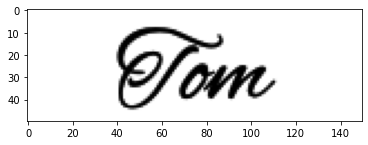

In [15]:
files = get_file_paths(font_data_paths[1]) 
show_one_image(files[222])

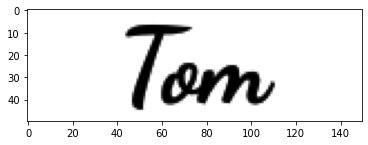

In [16]:
files = get_file_paths(font_data_paths[15]) 
show_one_image(files[222])

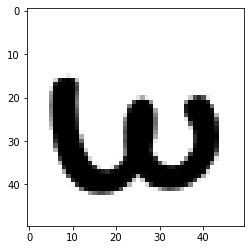

In [17]:
files = get_file_paths(font_data_paths[19]) 
show_one_image(files[310])

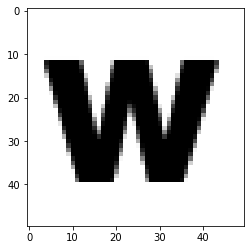

In [18]:
files = get_file_paths(font_data_paths[22]) 
show_one_image(files[310])

# Do preprocessing
## Load all images and labels

In [19]:
# Load all images and labels in a dictionary
all_data = load_all_font_data(font_data_paths, image_size, pixel_depth, verbose=False, params=params)

100%|██████████| 35/35 [00:09<00:00,  3.82it/s]


In [20]:
print("nb fonts: ", len(all_data))

nb fonts:  35


In [21]:
# Generate all datasets (images) and labels
images, labels, font_names = finalize_image_packaging(all_data, image_size)

# Show dimensions of datasets and labels
print(f"Images: {images.shape}, labels: {labels.shape}")

Images: (29050, 50, 50), labels: (29050,)


## Show images that are ready to use for Training

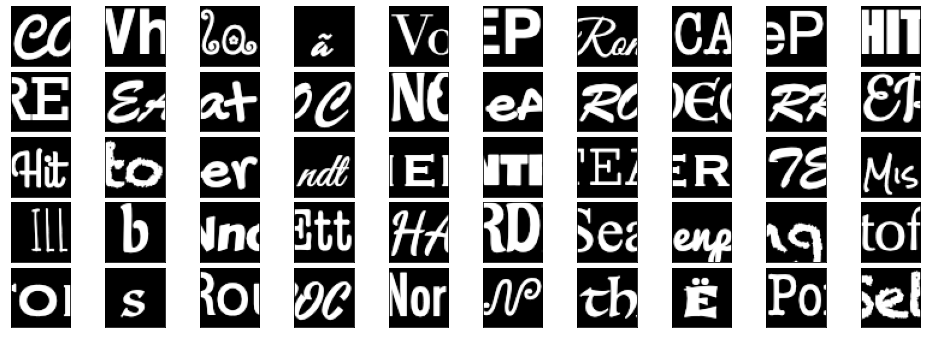

In [22]:
# Show 50 images
indices = np.random.choice(images.shape[0], 50, replace=False)
display_images(images[indices])

In [23]:
# Save images, labels and font names to single pickle file
save_to_pickle(
    OUT_DATAFILE,
    {
        'images': images,
        'labels': labels,
        'font_names': font_names
    }
)

In [24]:
print("Data for Training is in file:", OUT_DATAFILE)

Data for Training is in file: /private/var/folders/dg/d26lcf2j32x077lbqlcjld5h0000gn/T/com.pixtolab.GenerateFontImages/prep1/output/prep1.pickle


### ETL Completed